In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()


from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

In [62]:
df = ak.from_parquet("all_jets_v5.parquet")

In [3]:
df.fields

['jets', 'partons_matched', 'generator_info', 'lepton_partons']

In [67]:
(jets,
partons_matched,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

In [4]:
jets.prov

<Array [[2, 3, -1, 4, 5], ..., [1, 5, ..., -1]] type='584143 * var * float64'>

In [5]:
partons_matched.prov

<Array [[2, 3, None, 4, 5], ..., [1, ..., None]] type='584143 * var * ?float64'>

In [5]:
prov1_partons = partons_matched[partons_matched.prov == 1]
print(partons_matched.prov[:10].tolist())


[[2.0, 3.0, None, 4.0, 5.0], [5.0, 1.0, 5.0, 3.0, 2.0, 1.0], [2.0, 1.0, 3.0, 5.0], [4.0, 2.0, 1.0, None, 3.0, 1.0, None], [3.0, 2.0, 5.0, 1.0], [3.0, 1.0, 5.0, 5.0, 2.0], [5.0, 3.0, 5.0, None], [1.0, 3.0, 2.0, 5.0, 1.0, 4.0], [2.0, 1.0, 3.0, 1.0, None, 5.0], [5.0, 5.0, 2.0, None, 4.0, None, 1.0, 3.0]]


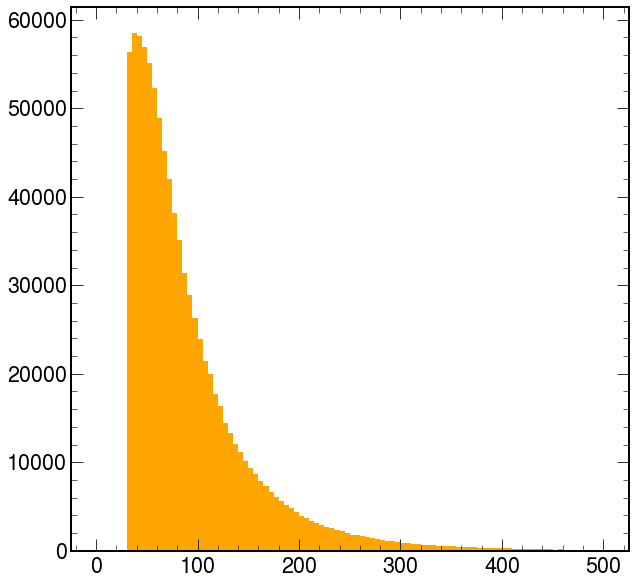

In [90]:
#find jets with provenance 1
prov1_jets = jets[partons_matched.prov == 1]

#plot the transverse momenta of these jets
plt.hist(ak.flatten(prov1_jets.pt), bins=100, range=(0, 500), color="orange")
plt.show()

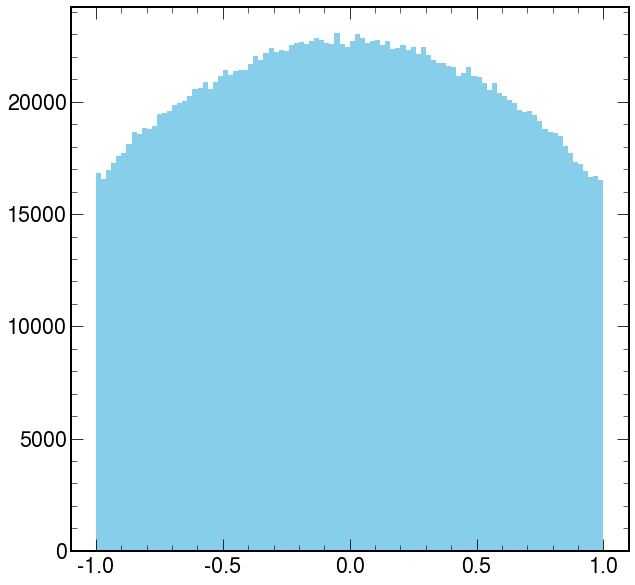

In [91]:
#find jets with |eta|<1
smalleta_jets = jets[np.abs(jets.eta) < 1.0]

#plot the eta of these jets
plt.hist(ak.flatten(smalleta_jets.eta), bins=100, color="skyblue")
plt.show()

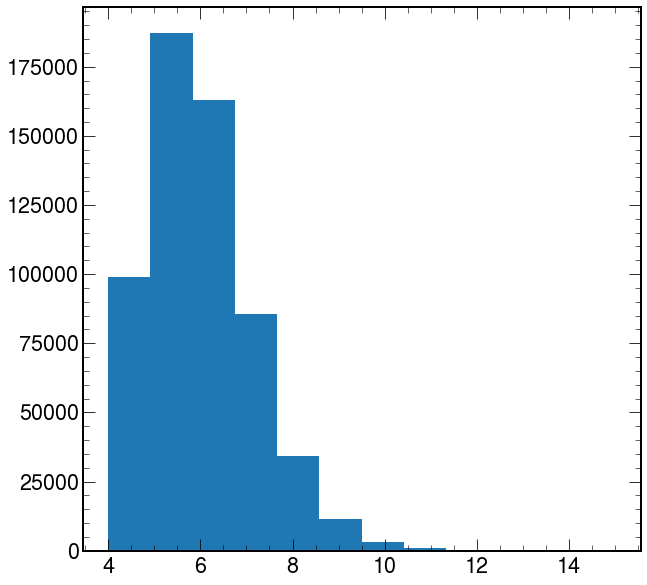

In [96]:
#count number of jets per event
jetnum = ak.num(jets.pt, axis=1)
plt.hist(jetnum, bins=12)
plt.show()

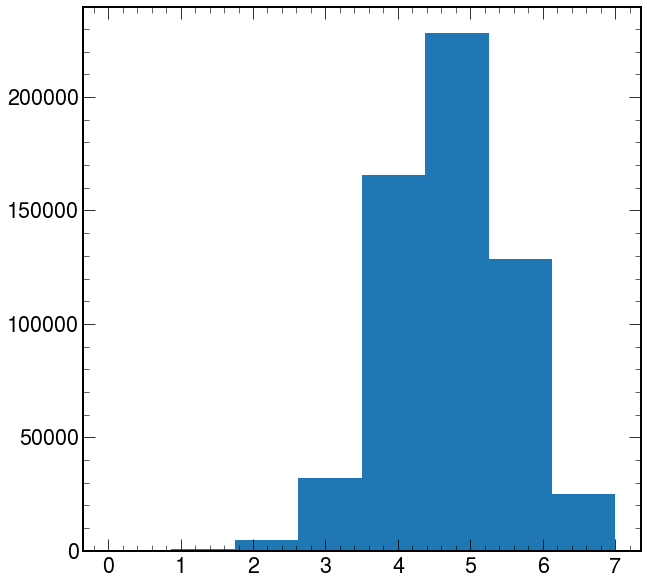

In [101]:
#count number of matched partons per event
partons_knownprov = partons_matched[partons_matched.prov != -999]
matchednum = ak.num(partons_knownprov.prov, axis=1)
plt.hist(matchednum, bins=8)
plt.show()

In [103]:
#count number of events with 2 matched jets coming from higgs (prov = 1)
jets_higgs = jets[partons_matched.prov == 1]
jets_2higgs = jets_higgs[ak.num(jets_higgs.pt, axis=1) == 2]
eventnum_2higgs = ak.num(jets_2higgs.pt, axis=0)
eventnum_2higgs

350930

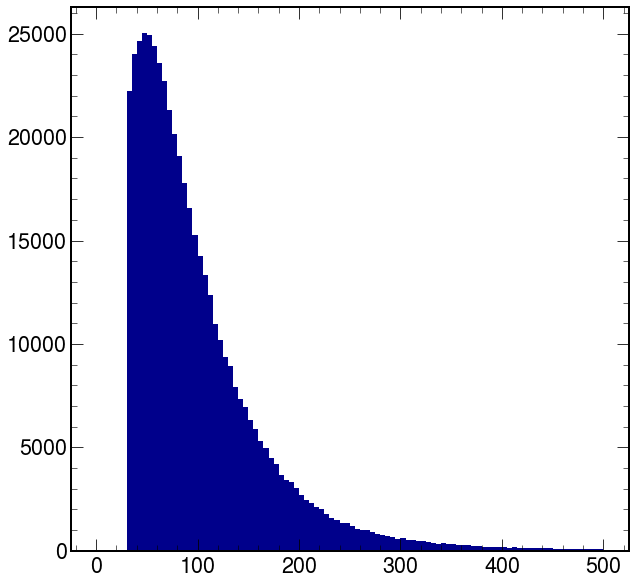

In [102]:
#find jets coming from hadronic top (prov = 2)
jets_htop = jets[partons_matched.prov == 2]

#plot pt of these jets
plt.hist(ak.flatten(jets_htop.pt), bins=100, color="darkblue", range=(0,500))
plt.show()

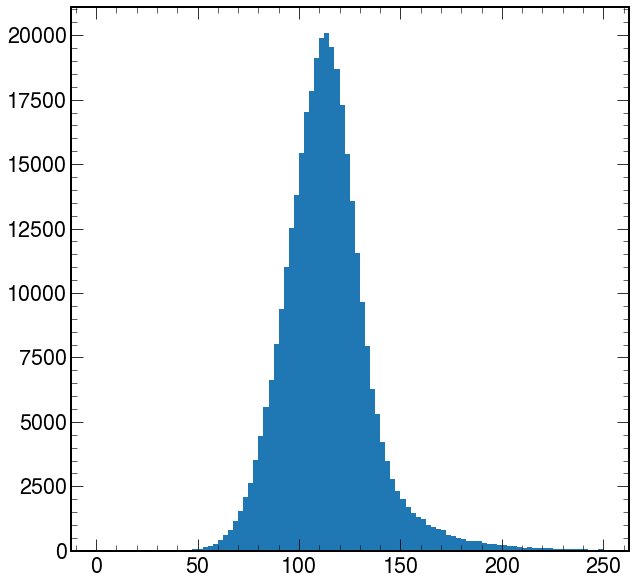

In [104]:
#invariant mass of two jets coming from higgs
summed_jets_higgs = jets_2higgs[:,0] + jets_2higgs[:,1]
plt.hist(summed_jets_higgs.mass, bins=100, range=(0,250))
plt.show()

In [105]:
def generate_summed(jets, partons, prov):
    jets_prov = jets[partons.prov == prov]
    jets_2prov = jets_prov[ak.num(jets_prov.pt, axis=1) == 2]
    summed_jets_prov = jets_2prov[:,0] + jets_2prov[:,1]
    
    partons_prov = partons[partons.prov == prov]
    partons_2prov = partons_prov[ak.num(partons_prov.pt, axis=1) == 2]
    summed_partons_prov = partons_2prov[:,0] + partons_2prov[:,1]
    return summed_jets_prov, summed_partons_prov

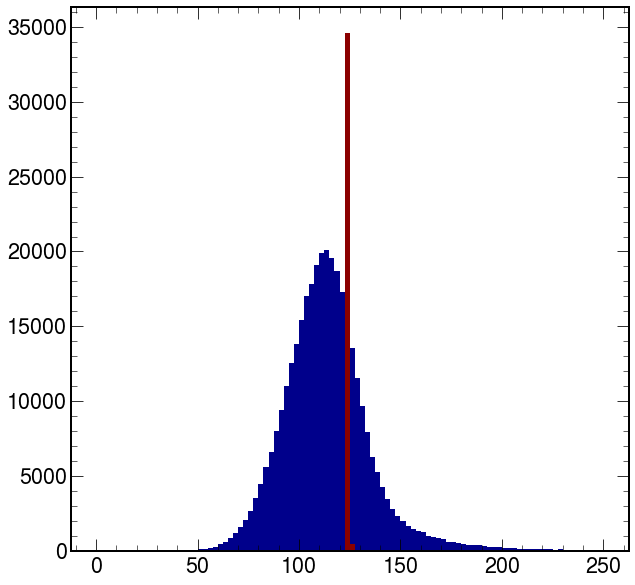

In [106]:
#invariant mass of the sum of the two jets associated with the Higgs
summed_jets_higgs, summed_partons_higgs = generate_summed(jets, partons_matched, 1)
plt.hist(summed_jets_higgs.mass, bins=100, range=(0,250), color="darkblue")

#invariant mass of the sum of the two partons associated with the Higgs
plt.hist(summed_partons_higgs.mass, weights=0.1*np.ones_like(summed_partons_higgs.mass), bins=100, range=(0,250), color="darkred")
plt.show()

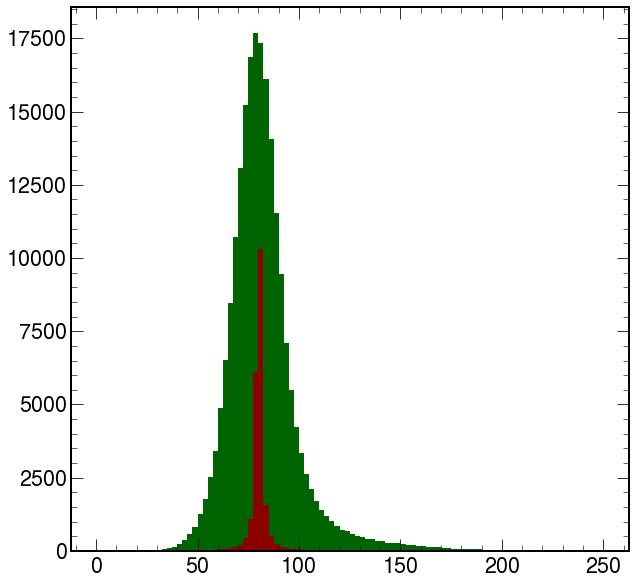

In [107]:
#invariant mass of the sum of the two jets associatied with the hadronically decaying W boson (prov = 5)

summed_jets_W, summed_partons_W = generate_summed(jets, partons_matched, 5)
plt.hist(summed_jets_W.mass, bins=100, range=(0,250), color="darkgreen")

#invariant mass of the sum of the two partons associatied with the hadronically decaying W boson (prov = 5)
plt.hist(summed_partons_W.mass, weights=0.1*np.ones_like(summed_partons_W.mass), bins=100, range=(0,250), color="darkred")
plt.show()


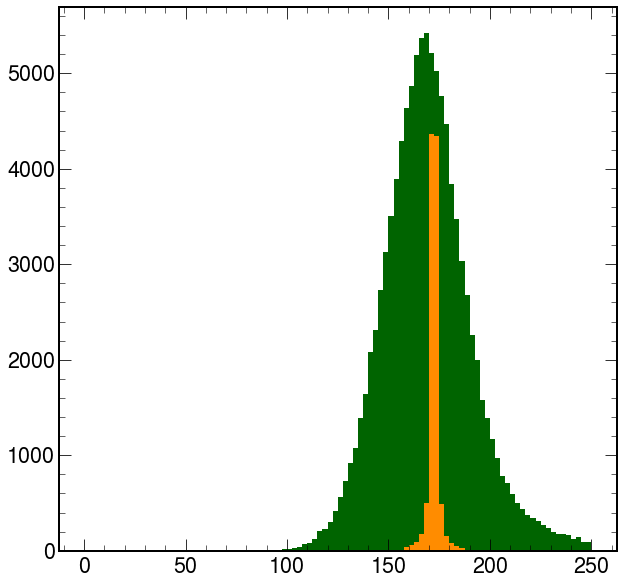

In [109]:
#invariant mass of top hadronically decaying

partons_with_2W = partons_matched[ak.sum(partons_matched.prov == 5, axis=1) == 2]
partons_with_1htop2W = partons_with_2W[ak.sum(partons_with_2W.prov == 2, axis=1) == 1]

jets_with_2W = jets[ak.sum(partons_matched.prov == 5, axis=1) == 2]
jets_with_1htop2W = jets_with_2W[ak.sum(partons_with_2W.prov == 2, axis=1) == 1]

summed_jets_W, summed_partons_W = generate_summed(jets_with_1htop2W, partons_with_1htop2W, 5)

jets_htop = jets_with_1htop2W[partons_with_1htop2W.prov == 2]
jets_1htop = jets_htop[ak.num(jets_htop.pt, axis=1) == 1]
summed_jets_htop = jets_1htop
    
partons_htop = partons_with_1htop2W[partons_with_1htop2W.prov == 2]
partons_1htop = partons_htop[ak.num(partons_htop.pt, axis=1) == 1]
summed_partons_htop = partons_1htop

total_sum_jets = summed_jets_W + summed_jets_htop
total_sum_partons = summed_partons_W + summed_partons_htop

plt.hist(total_sum_jets.mass, bins=100, range=(0,250), color="darkgreen")
plt.hist(total_sum_partons.mass, weights=0.1*np.ones_like(total_sum_partons.mass), bins=100, range=(0,250), color="darkorange")

plt.show()

# Boost

In [78]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [82]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

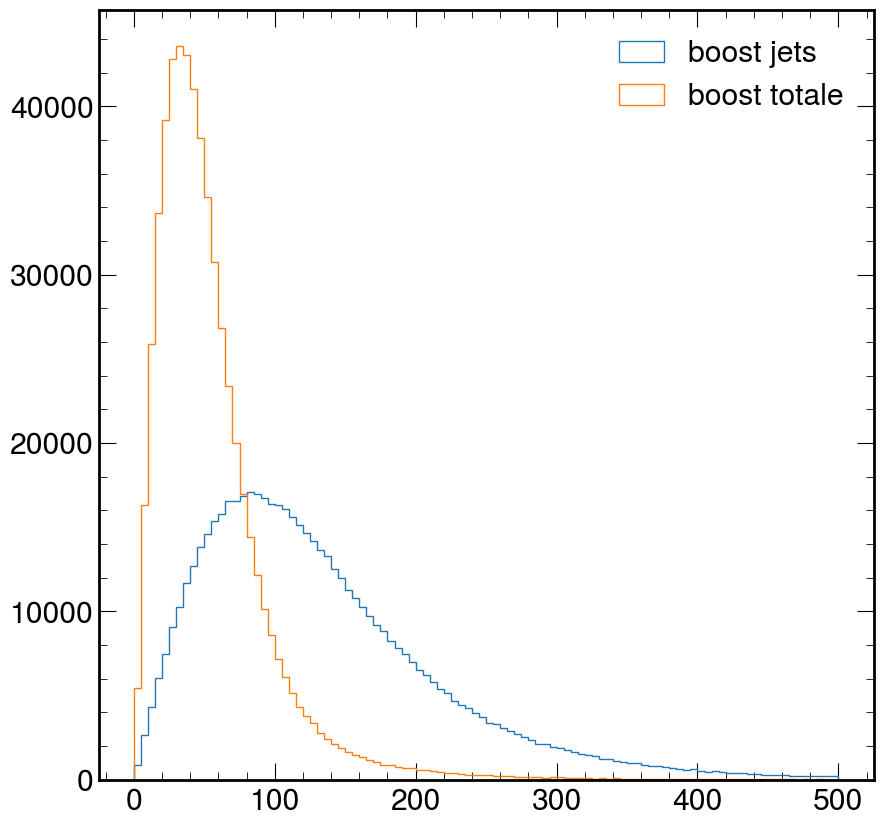

In [84]:
plt.hist(boost_jets.pt, bins=100, label="boost jets", range=(0, 500), histtype="step")
plt.hist(boost_reco.pt, bins=100, label="boost totale",range=(0, 500), histtype="step")
plt.legend()

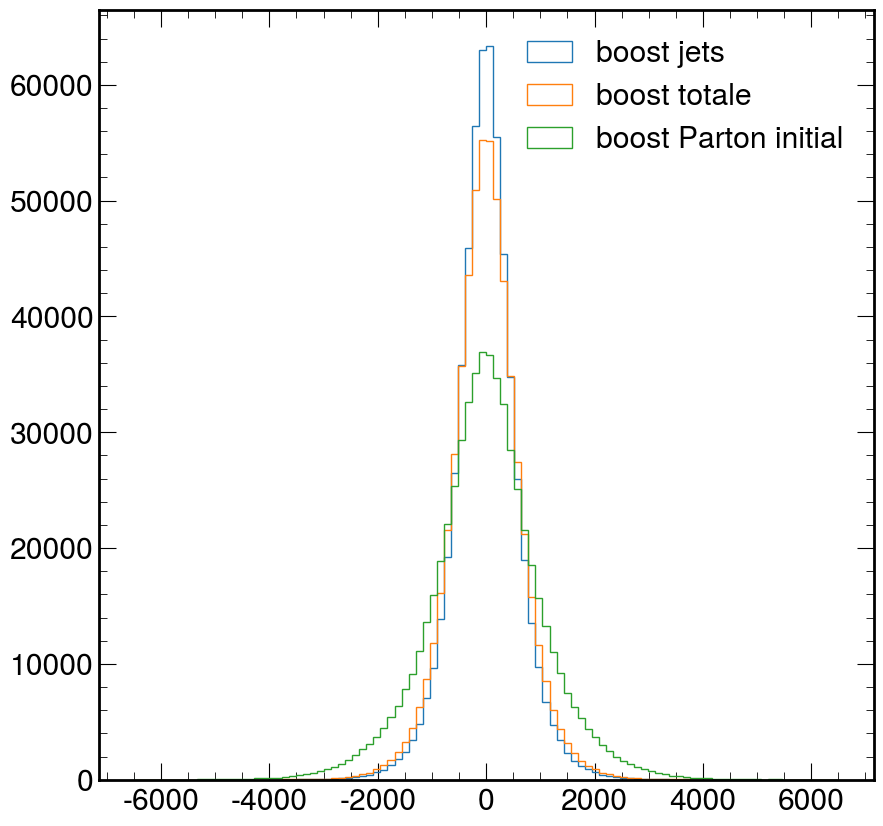

In [94]:
plt.hist(boost_jets.pz, bins=100, label="boost jets", range=(-6500, 6500), histtype="step")
plt.hist(boost_reco.pz, bins=100, label="boost totale",range=(-6500, 6500), histtype="step")
plt.hist(generator_info.x1 * 6500 - generator_info.x2 * 6500, bins=100, label="boost Parton initial",range=(-6500, 6500), histtype="step" )
plt.legend()

(array([4.0000e+00, 6.0000e+00, 5.0000e+00, 8.0000e+00, 7.0000e+00,
        1.5000e+01, 1.8000e+01, 1.8000e+01, 2.3000e+01, 3.7000e+01,
        3.7000e+01, 4.4000e+01, 5.3000e+01, 7.3000e+01, 1.0300e+02,
        9.5000e+01, 1.4500e+02, 1.6300e+02, 1.7900e+02, 2.4000e+02,
        3.1000e+02, 3.8300e+02, 4.5300e+02, 6.0200e+02, 7.1200e+02,
        8.4000e+02, 1.0550e+03, 1.2720e+03, 1.5540e+03, 1.9110e+03,
        2.3250e+03, 2.7410e+03, 3.2290e+03, 3.7840e+03, 4.5200e+03,
        5.3680e+03, 6.5680e+03, 7.5420e+03, 8.8230e+03, 1.0661e+04,
        1.2857e+04, 1.4894e+04, 1.7415e+04, 1.9998e+04, 2.2868e+04,
        2.6388e+04, 2.9344e+04, 3.1874e+04, 3.3718e+04, 3.4204e+04,
        3.3621e+04, 3.1811e+04, 2.9244e+04, 2.5998e+04, 2.3013e+04,
        1.9946e+04, 1.7271e+04, 1.4908e+04, 1.2784e+04, 1.0758e+04,
        9.0650e+03, 7.5610e+03, 6.4400e+03, 5.3870e+03, 4.5290e+03,
        3.8970e+03, 3.2040e+03, 2.6870e+03, 2.2250e+03, 1.8150e+03,
        1.5360e+03, 1.3120e+03, 1.0340e+03, 8.96

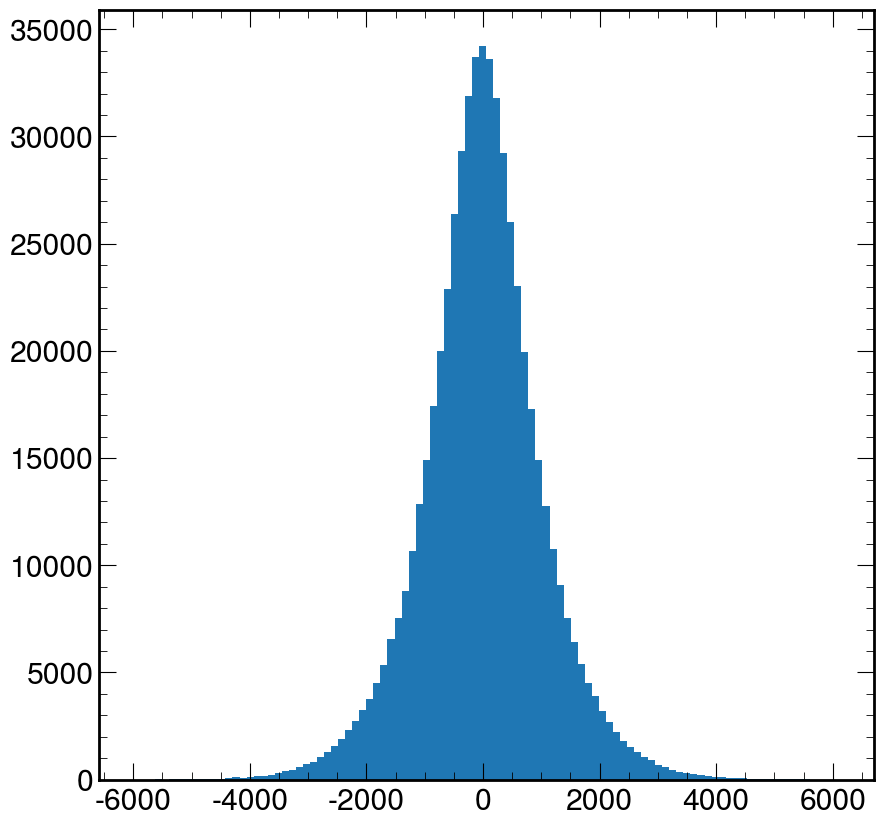

In [116]:
#TASK: Sum over all jets to calculate the total boost. Plot px, py, pz in histogramms.

boosts = sum(jets, axis=1)
boosts = ak.with_name(boosts, name="Momentum4D")
plt.figure(figsize=(8,8))
plt.title(r"$p_x$")
plt.hist(boosts.px, bins=100, color="teal", range=(-2000, 2000))
plt.show()

TypeError: 'axis' is an invalid keyword argument for sum()

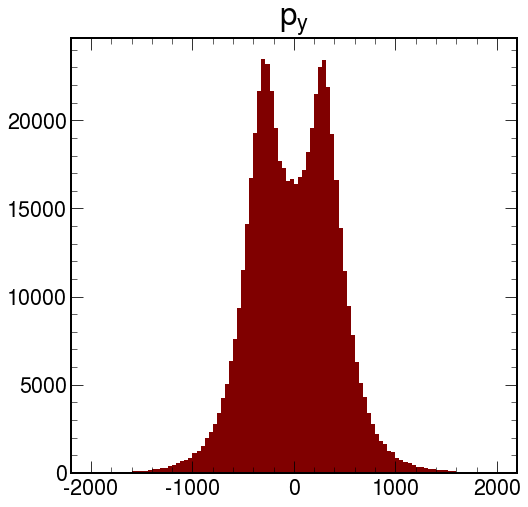

In [24]:
plt.figure(figsize=(8,8))
plt.title(r"$p_y$")
plt.hist(boosts.py, bins=100, color="maroon", range=(-2000, 2000))
plt.show()

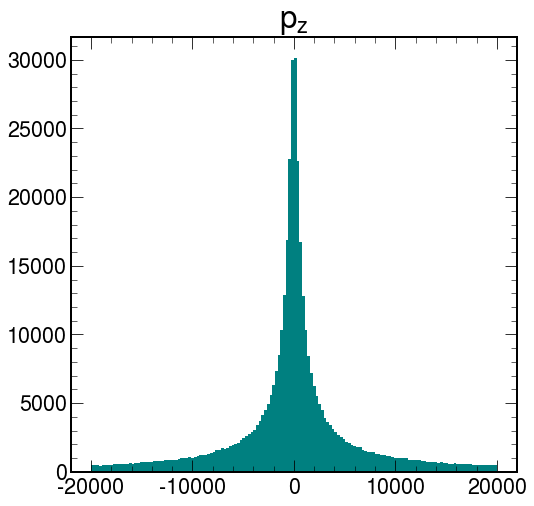

In [25]:
plt.figure(figsize=(8,8))
plt.title(r"$p_z$")
plt.hist(boosts.pz, bins=150, color="teal", range=(-20000, 20000))
plt.show()

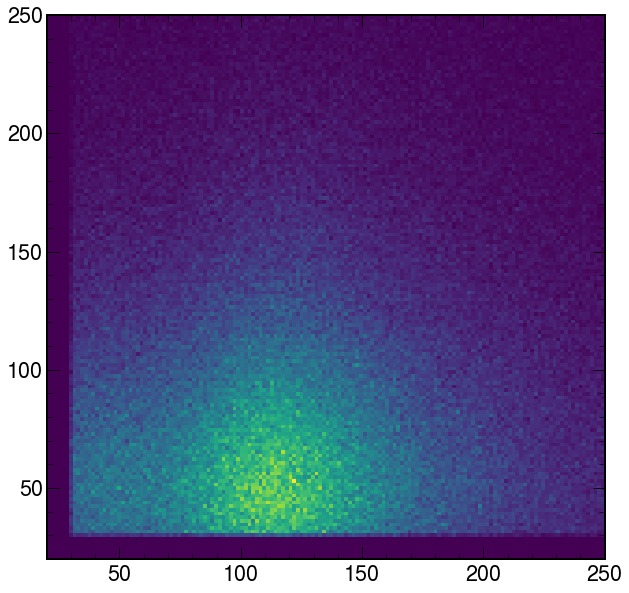

In [117]:
#pt of higgs vs pt of htop, without selecting only 2higgs events
mask1 = ak.sum(partons_matched.prov == 1, axis=1) != 0

jets_with_higgs = jets[mask1]
partons_with_higgs = partons_matched[mask1]

mask2 = ak.sum(partons_with_higgs.prov == 2, axis=1) != 0

jets_with_htop_higgs = jets_with_higgs[mask2]
partons_with_htop_higgs = partons_with_higgs[mask2]
higgs_jets = jets_with_htop_higgs[partons_with_htop_higgs.prov == 1]
htop_jets = jets_with_htop_higgs[partons_with_htop_higgs.prov == 2]
higgs_pt = ak.sum(higgs_jets.pt, axis=1)
htop_pt = ak.sum(htop_jets.pt, axis=1) #for dimensionality
plt.hist2d(higgs_pt, htop_pt, bins=(150,150), range=[[20, 250], [20, 250]])
plt.show()

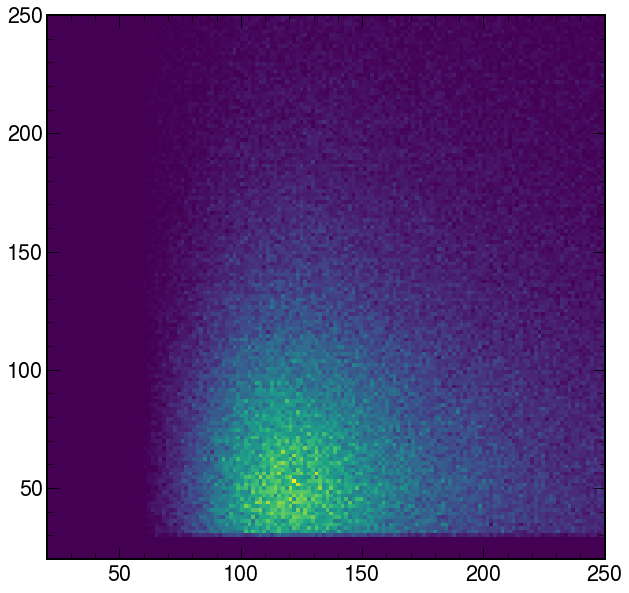

In [118]:
#with selecting 2higgs events
mask1 = ak.sum(partons_matched.prov == 1, axis=1) == 2

jets_with_higgs = jets[mask1]
partons_with_higgs = partons_matched[mask1]

mask2 = ak.sum(partons_with_higgs.prov == 2, axis=1) == 1

jets_with_htop_higgs = jets_with_higgs[mask2]
partons_with_htop_higgs = partons_with_higgs[mask2]
higgs_jets = jets_with_htop_higgs[partons_with_htop_higgs.prov == 1]
htop_jets = jets_with_htop_higgs[partons_with_htop_higgs.prov == 2]
higgs_pt = ak.sum(higgs_jets.pt, axis=1)
htop_pt = ak.sum(htop_jets.pt, axis=1) #for dimensionality

plt.hist2d(higgs_pt, htop_pt, bins=(150,150), range=[[20, 250], [20, 250]])
plt.show()

In [119]:
#selects events which include a given provenance (particle) with a certain multiplicity.
#provs: array of provenances;   mults: corresponding multiplicities
def select_include(jets, partons, provs, mults):
    new_jets = jets
    new_partons = partons
    for (prov, mult) in zip(provs, mults):
        if mult == -1: 
            new_jets = new_jets[ak.sum(new_partons.prov == prov, axis=1) != 0]
            new_partons = new_partons[ak.sum(new_partons.prov == prov, axis=1) != 0]
        else:
            new_jets = new_jets[ak.sum(new_partons.prov == prov, axis=1) == mult]
            new_partons = new_partons[ak.sum(new_partons.prov == prov, axis=1) == mult]
    return new_jets, new_partons

#selects only those jets/partons of a given provenance (particle)
def select_only(jets, partons, prov):
    new_jets = jets[partons.prov == prov]
    new_partons = partons[partons.prov == prov]
    return new_jets, new_partons


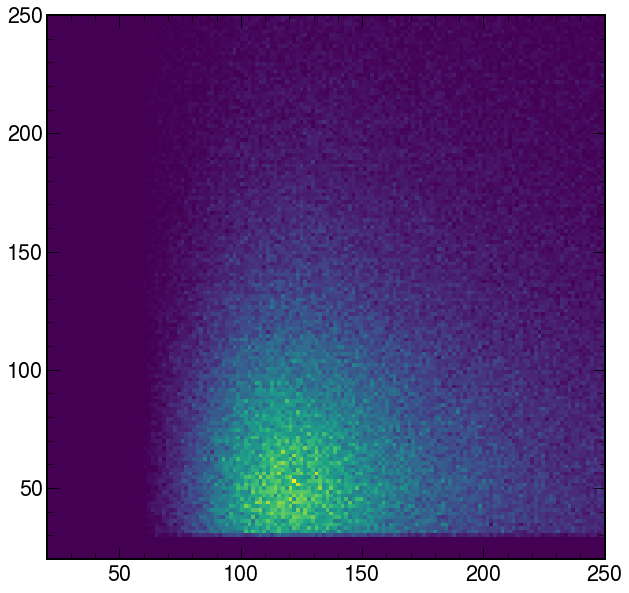

In [120]:
#previous example with new functions
jets_with_2higgs1htop, partons_with_2higgs1htop = select_include(jets, partons_matched, [1, 2], [2, 1])
higgs_jets, higgs_partons = select_only(jets_with_2higgs1htop, partons_with_2higgs1htop, 1)
htop_jets, htop_partons = select_only(jets_with_2higgs1htop, partons_with_2higgs1htop, 2)
higgs_pt = ak.sum(higgs_jets.pt, axis=1)
htop_pt = ak.sum(htop_jets.pt, axis=1)

plt.hist2d(higgs_pt, htop_pt, bins=(150,150), range=[[20, 250], [20, 250]])
plt.show()

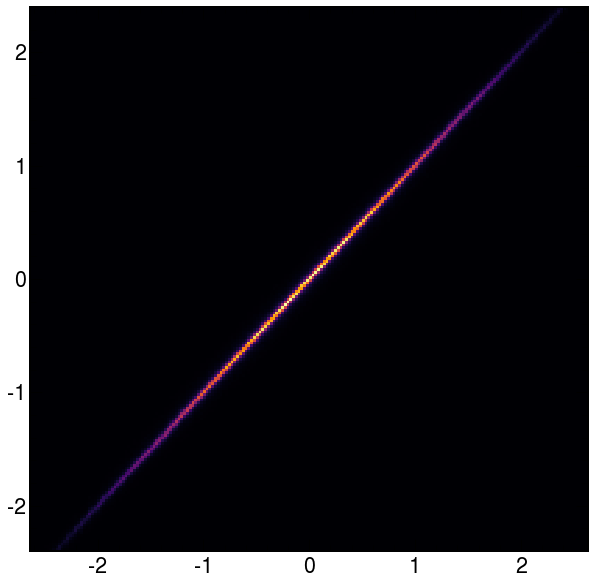

In [121]:
#eta of higgs vs eta of partons
higgs_jets, higgs_partons = select_only(jets, partons_matched, 1)
jet_eta = higgs_jets.eta
parton_eta = higgs_partons.eta
jet_eta = ak.flatten(jet_eta)
parton_eta = ak.flatten(parton_eta)

plt.hist2d(parton_eta, jet_eta, bins=(200,200), cmap="inferno")
plt.show()

In [32]:
generator_info.fields

['pdgid1', 'pdgid2', 'x1', 'x2']

In [ ]:
#TODO: explore generator_info, lepton_partons